In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
import pandas as pd
import numpy as np

In [58]:
# Loading the csv files
import os

root_dir = "/content/drive/MyDrive/ds_madhulika_chandel/csv_files"
output_dir = "/content/drive/MyDrive/ds_madhulika_chandel/outputs"

traders_df = pd.read_csv(os.path.join(root_dir, "historical_data.csv"))
sentiment_df = pd.read_csv(os.path.join(root_dir, "fear_greed_index.csv"))

In [59]:
traders_df.sample(5)
#traders_df.size
#traders_df.shape
#traders_df.info()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
153623,0x2c229d22b100a7beb69122eed721cee9b24011dd,ANIME,0.10895,278.00,30.29,BUY,22-01-2025 15:32,23003.00000,Open Long,0.000000,0xbfc422a9f0a2c630a911041c1e8702017d003a14299d...,65567483796,True,0.010600,6.820000e+14,1.740000e+12
132038,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,PURR/USDC,0.30573,817.00,249.78,SELL,01-12-2024 19:50,42723.23248,Sell,58.158385,0x7695201026fb5c328c3c041829d0950177009ec5216e...,51693897847,True,0.087423,3.430000e+14,1.730000e+12
23933,0x4f93fead39b70a1824f981a54d4e55b278e9f760,BTC,88270.00000,0.01,882.70,BUY,14-11-2024 21:20,0.33630,Open Long,0.000000,0x9fa288b2c2ad75c16bea0416ca5c0e02031f000dee1b...,47263741613,True,0.264810,5.580000e+14,1.730000e+12
34446,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,RUNE,1.54070,325.00,500.73,BUY,01-02-2025 19:31,-62619.50000,Close Short,6.955000,0xe51e5cfaa4674e5dd647041cef9da102015100060234...,68231669843,False,0.048069,4.870000e+14,1.740000e+12
180988,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,HYPE,14.78300,35.52,525.09,BUY,19-03-2025 15:44,10544.05000,Open Long,0.000000,0x0b1b828dbea1bc0ad47c041fd9c3fc018e0067c7f292...,80697127322,True,0.157527,5.570000e+14,1.740000e+12


In [ ]:
traders_df["Timestamp IST"]

,Timestamp IST
0,02-12-2024 22:50
1,02-12-2024 22:50
2,02-12-2024 22:50
3,02-12-2024 22:50
4,02-12-2024 22:50
...,...
211219,25-04-2025 15:35
211220,25-04-2025 15:35
211221,25-04-2025 15:35
211222,25-04-2025 15:35


In [ ]:
traders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [ ]:
sentiment_df.info()
#sentiment_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [ ]:
sentiment_df["date"]

,date
0,2018-02-01
1,2018-02-02
2,2018-02-03
3,2018-02-04
4,2018-02-05
...,...
2639,2025-04-28
2640,2025-04-29
2641,2025-04-30
2642,2025-05-01


In [60]:
#Converting Timestamp IST and date to datetime. So they can be merged going forward.

traders_df["date"] = pd.to_datetime(traders_df['Timestamp IST'], dayfirst=True).dt.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

In [61]:
# Only considering closed trades, because we are analyzing daily PnL trends,
# sentiment effects, leverage behavior, etc., we need realized results, not floating ones.

closed_trades = traders_df[traders_df['Direction'].str.contains('Close')]

In [62]:
# Aggregating all trades of a day for easy plotting and analysis.
# Also generating meaningful columns that are our main objective.

daily_trades = closed_trades.groupby('date').agg(
    avg_daily_pnl=('Closed PnL', 'mean'),
    total_daily_volume=('Size USD', 'sum'),
    avg_daily_leverage=('Start Position', lambda x: x.abs().mean()),
    unique_accounts=('Account', 'nunique'),
    num_trades=('Trade ID', 'count'),
    buy_ratio=('Side', lambda x: (x.str.upper() == 'BUY').mean())
).reset_index()

Merging both daily_trades and sentiment_df.

In [63]:
agg_merged_df = pd.merge(
    daily_trades,
    sentiment_df[['date', 'classification', 'value']],
    on='date',
    how='left'   # keep all trader rows even if sentiment is missing
)

In [64]:
agg_merged_df.sample(5)

,date,avg_daily_pnl,total_daily_volume,avg_daily_leverage,unique_accounts,num_trades,buy_ratio,classification,value
9,2023-12-25,-245.081348,29851.65,13.190600,1,1,0.000000,Greed,73.0
341,2025-02-22,74.257327,1594772.86,271498.238767,9,334,0.494012,Neutral,49.0
53,2024-02-15,30.679961,146456.72,3586.588801,2,60,0.866667,Greed,72.0
136,2024-06-01,10.167824,6371.53,65507.022222,1,9,1.000000,Greed,72.0
262,2024-12-05,41.496155,377486.70,1085.953975,5,164,0.780488,Extreme Greed,84.0


As we can see value is negatively correlated with avg_daily_PnL meaning they must be inversely proportional.

In [65]:
agg_merged_df[['value', 'avg_daily_pnl']].corr()

,value,avg_daily_pnl
value,1.00000,-0.07858
avg_daily_pnl,-0.07858,1.00000


#Visualization

The philosophy,by Warren Buffett, is to "be fearful when others are greedy, and greedy when others are fearful." seems true here.

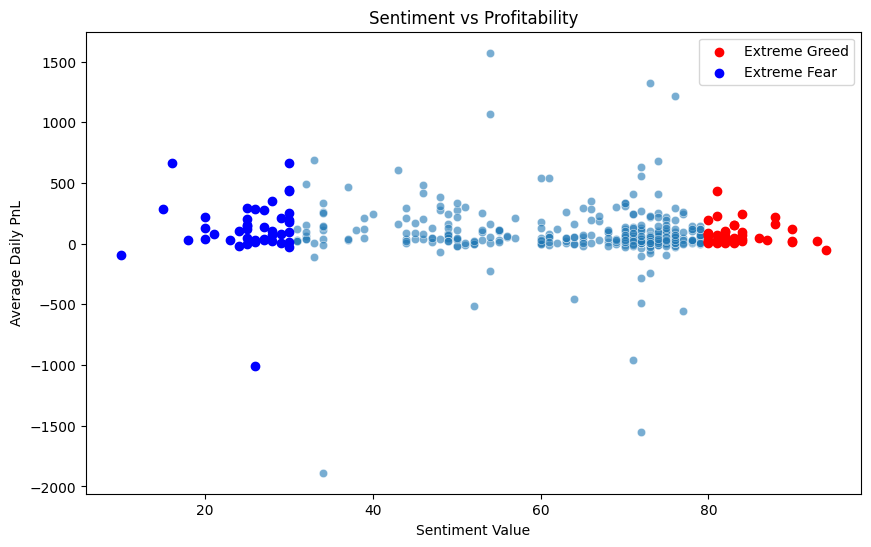

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x='value', y='avg_daily_pnl', data=agg_merged_df, alpha=0.6)

# Highlight "extreme" sentiment days
extreme_greed = agg_merged_df[agg_merged_df['value'] >= agg_merged_df['value'].quantile(0.9)]
extreme_fear = agg_merged_df[agg_merged_df['value'] <= agg_merged_df['value'].quantile(0.1)]
plt.scatter(extreme_greed['value'], extreme_greed['avg_daily_pnl'], color='red', label='Extreme Greed')
plt.scatter(extreme_fear['value'], extreme_fear['avg_daily_pnl'], color='blue', label='Extreme Fear')

plt.xlabel('Sentiment Value')
plt.ylabel('Average Daily PnL')
plt.title('Sentiment vs Profitability')
plt.legend()
plt.show()
plt.savefig(os.path.join(output_dir, "Sentiment_vs_Profitability"), dpi=300, bbox_inches='tight')
plt.close()





Leverage theoretically amplifies risk, but in practice, it does not seem to be the main driver of large swings for this dataset.

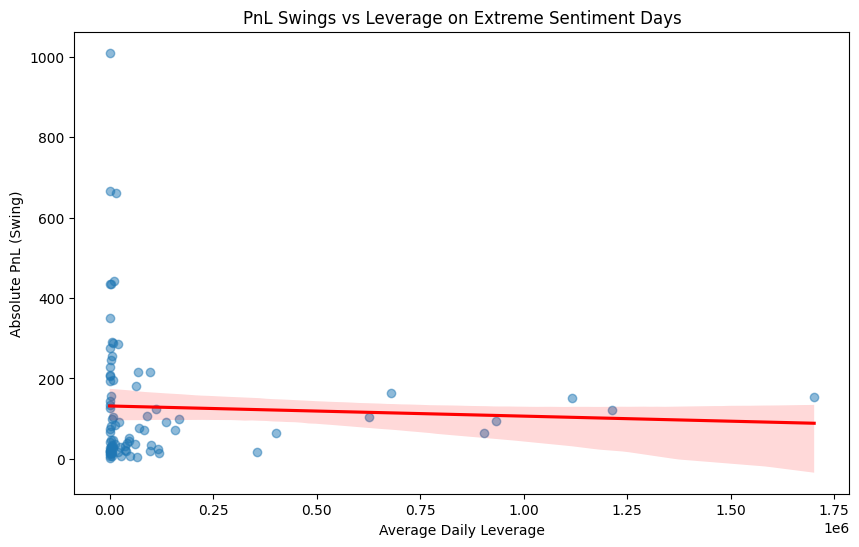

In [67]:
extreme_days = pd.concat([extreme_greed, extreme_fear])
extreme_days['abs_pnl'] = extreme_days['avg_daily_pnl'].abs()

plt.figure(figsize=(10,6))
sns.regplot(x='avg_daily_leverage', y='abs_pnl', data=extreme_days, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Average Daily Leverage')
plt.ylabel('Absolute PnL (Swing)')
plt.title('PnL Swings vs Leverage on Extreme Sentiment Days')
plt.show()
plt.savefig(os.path.join(output_dir, "PnL_vs_Leverage"), dpi=300, bbox_inches='tight')
plt.close()


The median leverage is  highest during extremely Greedy days whereas it is lower during Fear days, which means that traders take less during fear days.

The outliers show that the highest leverage events happen during "Fear" and "Extreme Greed" days backing up the contrarian theory.

/tmp/ipython-input-3913678474.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y='avg_daily_leverage', data=agg_merged_df,


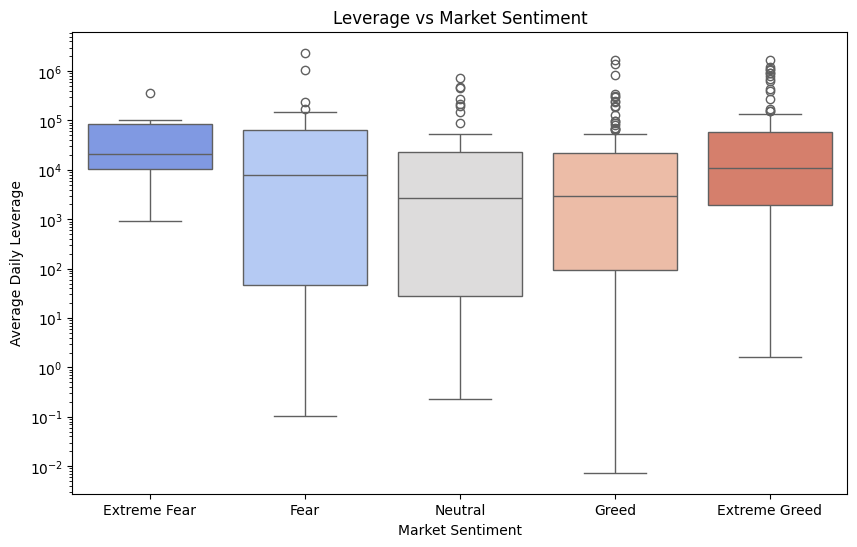

In [73]:
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='avg_daily_leverage', data=agg_merged_df,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'],
            palette='coolwarm')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Daily Leverage')
plt.title('Leverage vs Market Sentiment')
plt.yscale('log')  # scale helps visualization
plt.show()
plt.savefig(os.path.join(output_dir, "Sentiment_vs_Leverage"), dpi=300, bbox_inches='tight')
plt.close()

 Highest number of trades are done when the market is Greedy but during fear too the number of trades does not drop that much.

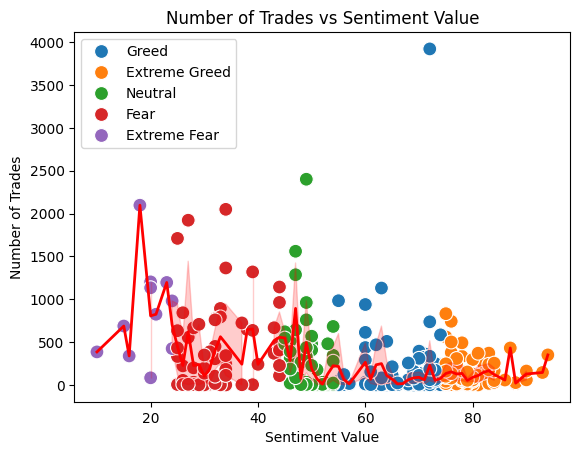

In [74]:
sns.scatterplot(x='value', y='num_trades', data=agg_merged_df, hue='classification', s=100)
sns.lineplot(x='value', y='num_trades', data=agg_merged_df, color='red', lw=2)
plt.title('Number of Trades vs Sentiment Value')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Trades')
plt.show()
plt.savefig(os.path.join(output_dir, "Sentiment_vs_Num_trades"), dpi=300, bbox_inches='tight')
plt.close()


Daily trading volume doesn’t strongly predict PnL — extreme profits or losses usually happen on moderate to high volume days across various sentiment conditions, while most days, regardless of volume or sentiment, have PnL near zero.

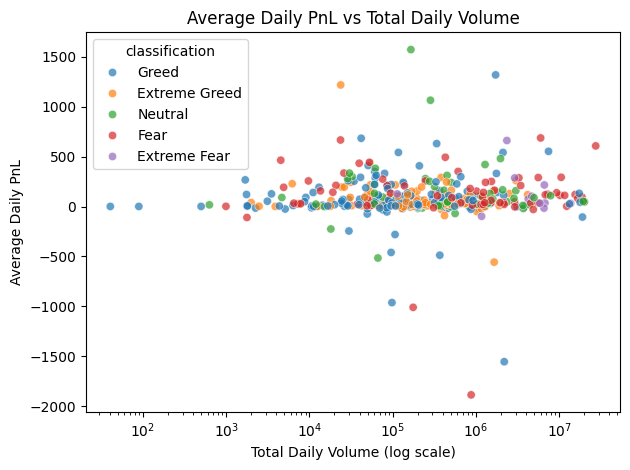

In [70]:
sns.scatterplot(
    x='total_daily_volume',
    y='avg_daily_pnl',
    data=agg_merged_df,
    hue='classification',
    alpha=0.7
)

plt.xscale('log')  # log scale for volume
plt.title('Average Daily PnL vs Total Daily Volume')
plt.xlabel('Total Daily Volume (log scale)')
plt.ylabel('Average Daily PnL')
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(output_dir, "PnL_vs_Volume"), dpi=300, bbox_inches='tight')
plt.close()


Buy ratio is higher dusring greedy days and vice versa.

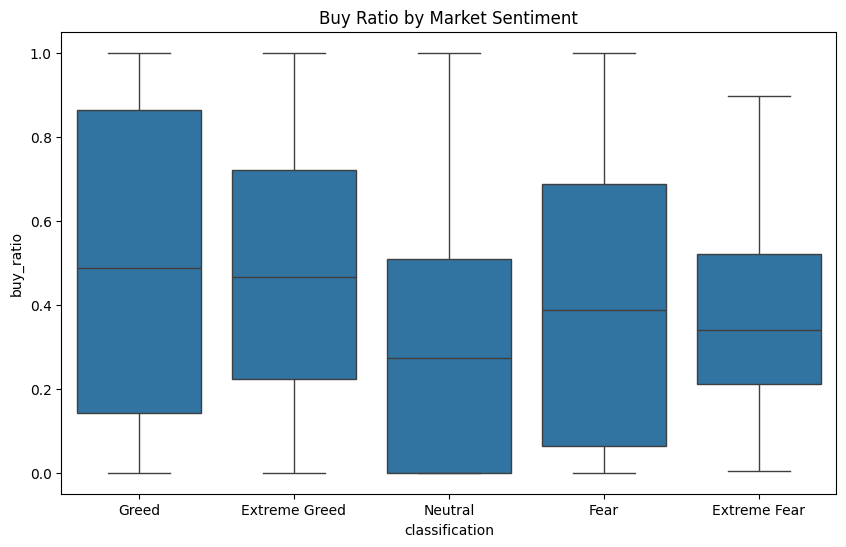

In [75]:
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='buy_ratio', data=agg_merged_df)
plt.title('Buy Ratio by Market Sentiment')
plt.show()
plt.savefig(os.path.join(output_dir, "Sentiment_vs_Buy_Ratio"), dpi=300, bbox_inches='tight')
plt.close()


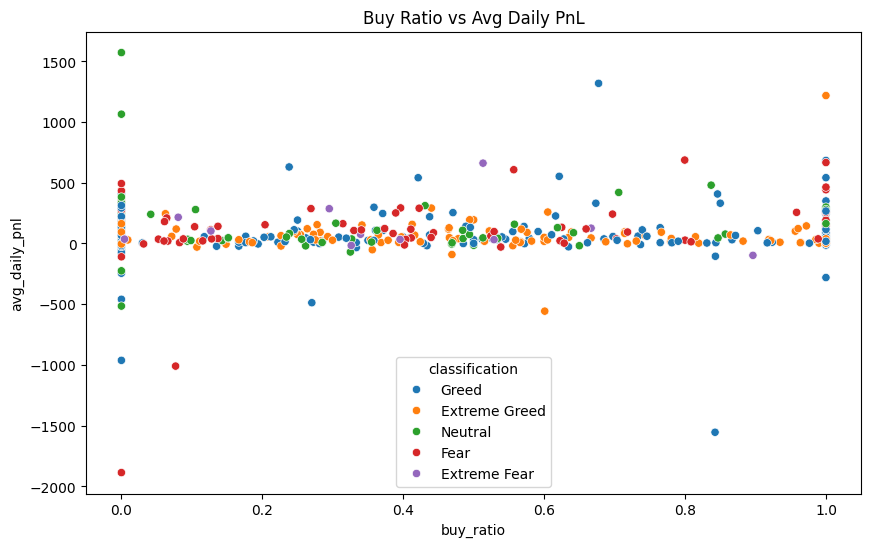

In [72]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='buy_ratio', y='avg_daily_pnl', hue='classification', data=agg_merged_df)
plt.title('Buy Ratio vs Avg Daily PnL')
plt.show()
plt.savefig(os.path.join(output_dir, "PnL_vs_Buy_Ratio"), dpi=300, bbox_inches='tight')
plt.close()

I tried calculating the rolling average of 3 days but after aggregating the data it turns out it is only for a month or so, therefore the 3-day sentiment rolling average does not appear to be a strong leading  for predicting the magnitude or direction of the Daily PnL.

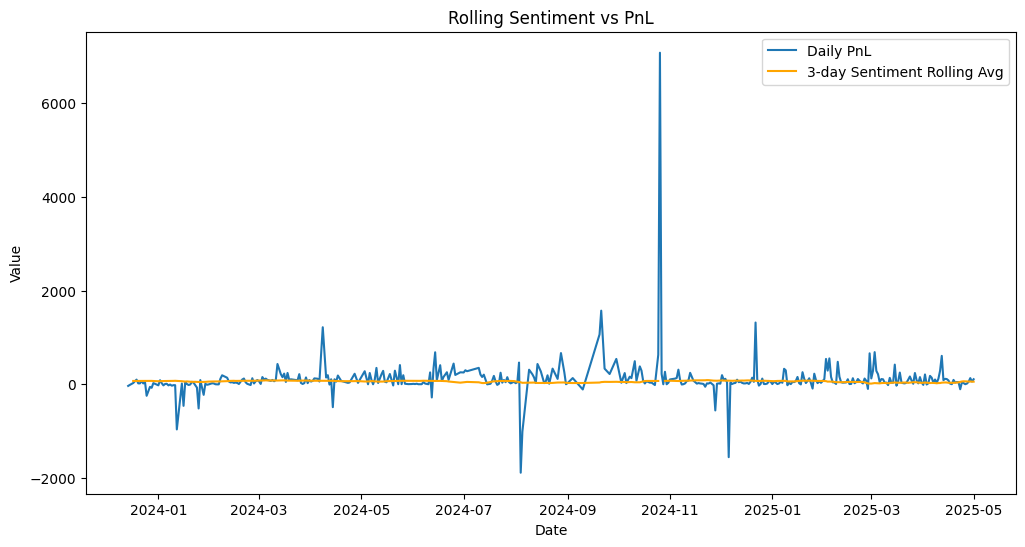

In [76]:
agg_merged_df['date'] = pd.to_datetime(agg_merged_df['date'])
df_time_series = agg_merged_df.sort_values('date').reset_index(drop=True)

window = 3
df_time_series['sentiment_rolling'] = df_time_series['value'].rolling(window=window).mean()
df_time_series['pnl_rolling'] = df_time_series['avg_daily_pnl'].rolling(window=window).mean()

plt.figure(figsize=(12,6))
plt.plot(df_time_series['date'], df_time_series['avg_daily_pnl'], label='Daily PnL')
plt.plot(df_time_series['date'], df_time_series['sentiment_rolling'], label=f'{window}-day Sentiment Rolling Avg', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Rolling Sentiment vs PnL')
plt.show()
plt.savefig(os.path.join(output_dir, "PnL_vs_Rolling_Sentiment"), dpi=300, bbox_inches='tight')
plt.close()

# Visualization by merging without aggregating

In [77]:
merged_df = pd.merge(
    traders_df,
    sentiment_df[['date', 'classification', 'value']],
    on='date',
    how='left'
)

In [78]:
# As original historical columns did not have any missing values so, we check only for the newly introduced classification column.
print(merged_df['classification'].isnull().sum())

6


In [79]:
# As there are only six missing values, I'm just dropping them.
merged_df = merged_df.dropna(subset=['classification'])

#**Account**

account behavior varies across market conditions and can tell us which account is more greedy or fearful.

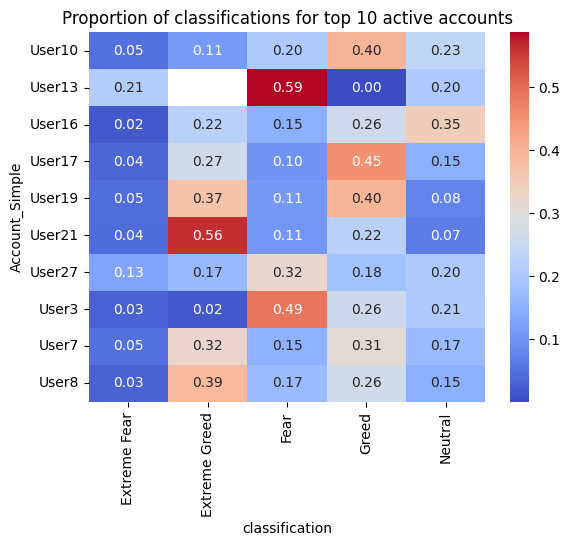

In [80]:
unique_accounts = merged_df['Account'].unique()
mapping = {acc: f'User{i+1}' for i, acc in enumerate(unique_accounts)}
merged_df['Account_Simple'] = merged_df['Account'].map(mapping)
merged_df['Account_Simple'].value_counts()


top_accounts = merged_df['Account_Simple'].value_counts().head(10).index
account_class_top = merged_df[merged_df['Account_Simple'].isin(top_accounts)].groupby('Account_Simple')['classification'].value_counts(normalize=True).unstack()

sns.heatmap(account_class_top, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Proportion of classifications for top 10 active accounts")
plt.show()
plt.savefig(os.path.join(output_dir, "Top_10_Users"), dpi=300, bbox_inches='tight')
plt.close()

#**Coin**


This graph shows that the coins on left offer high risk and high loss conditions whereas the right ones are associated with modest trading outcomes.

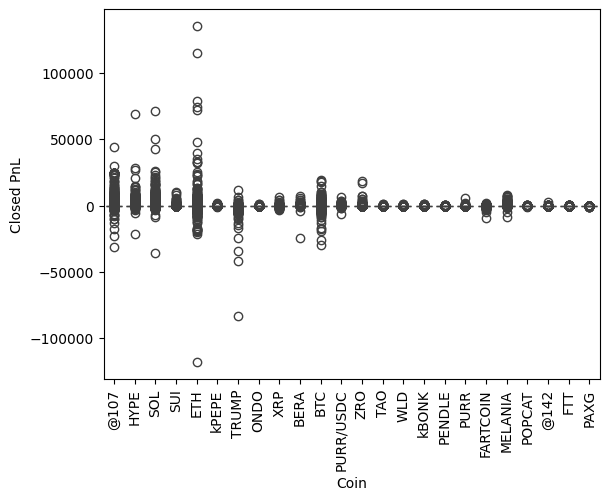

In [81]:
value_coins=merged_df['Coin'].value_counts()
coin_counts = merged_df['Coin'].value_counts()
top_coins=coin_counts[coin_counts > 1000].index


sns.boxplot(
    x='Coin',
    y='Closed PnL',
    data=merged_df[merged_df['Coin'].isin(top_coins)]
)
plt.xticks(rotation=90)
plt.show()
plt.savefig(os.path.join(output_dir, "PnL_vs_Coin"), dpi=300, bbox_inches='tight')
plt.close()

The distribution of trades if heavily skewed as only a few coins are traded mostly
we can also notice that the coins having high loss and profit values used more compared to moderate loss and profit ones.

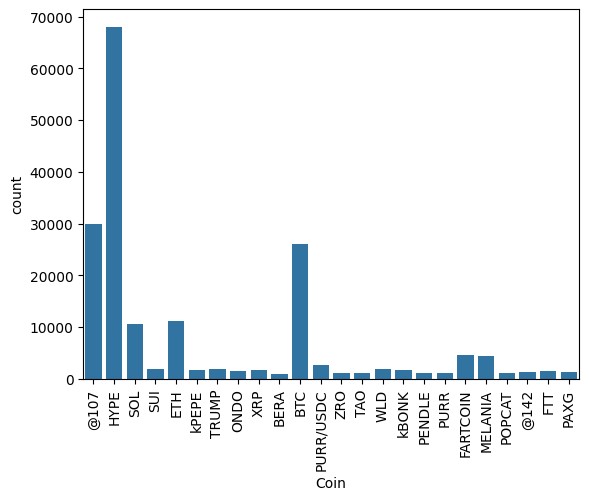

In [82]:
sns.countplot(x='Coin', data=merged_df[merged_df['Coin'].isin(top_coins)])
plt.xticks(rotation=90)
plt.show()
plt.savefig(os.path.join(output_dir, "Volume_vs_Coin"), dpi=300, bbox_inches='tight')
plt.close()

#**Execution Price**

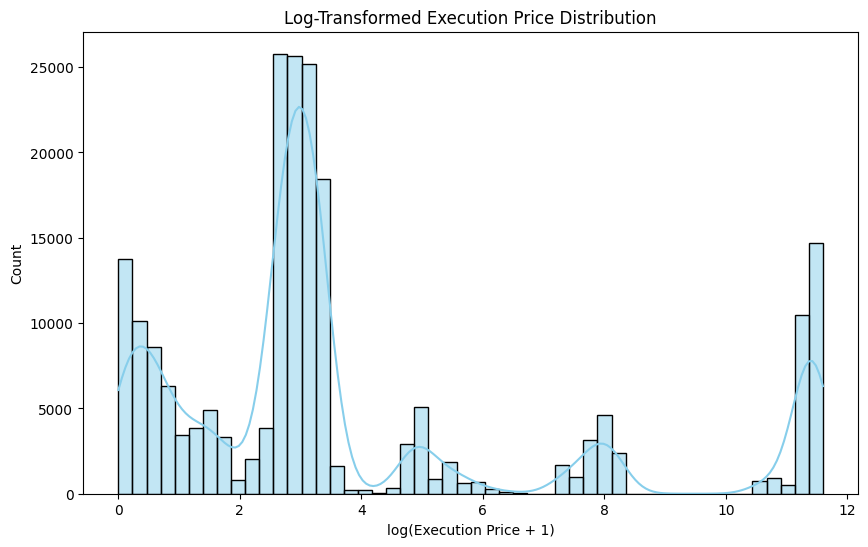

In [84]:
merged_df['Execution Price'].describe()
merged_df['ExecutionPrice_log'] = np.log1p(merged_df['Execution Price'])
lower = merged_df['Execution Price'].quantile(0.01)
upper = merged_df['Execution Price'].quantile(0.99)

merged_df['Execution Price Capped'] = merged_df['Execution Price'].clip(lower, upper)

plt.figure(figsize=(10,6))
sns.histplot(merged_df['ExecutionPrice_log'], bins=50, kde=True, color='skyblue')
plt.title('Log-Transformed Execution Price Distribution')
plt.xlabel('log(Execution Price + 1)')
plt.ylabel('Count')
plt.show()

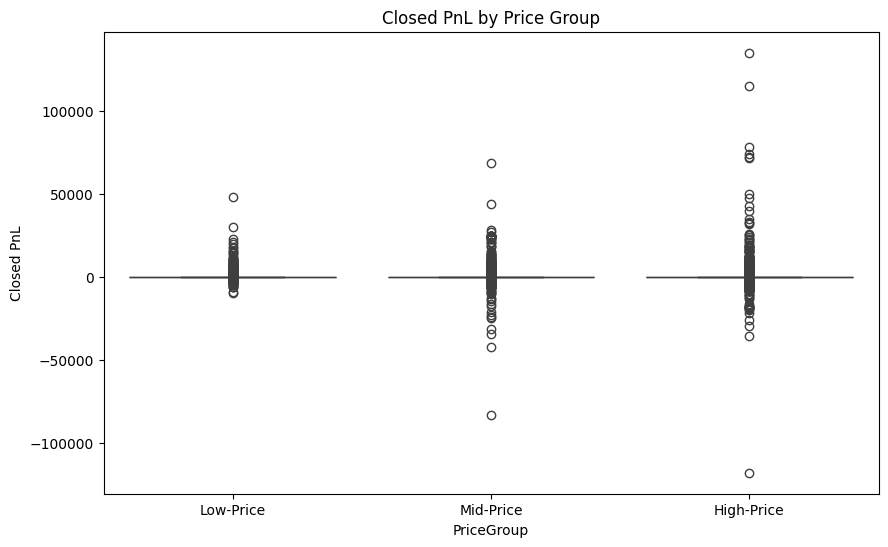

In [85]:
bins = [0, np.log1p(10), np.log1p(100), np.log1p(merged_df['Execution Price'].max())]
labels = ['Low-Price', 'Mid-Price', 'High-Price']


merged_df['PriceGroup'] = pd.cut(merged_df['ExecutionPrice_log'], bins=bins, labels=labels)
plt.figure(figsize=(10,6))
sns.boxplot(x='PriceGroup', y='Closed PnL', data=merged_df)
plt.title('Closed PnL by Price Group')
plt.show()
plt.savefig(os.path.join(output_dir, "PnL_by_Price_Group"), dpi=300, bbox_inches='tight')
plt.close()

#**Size USD**

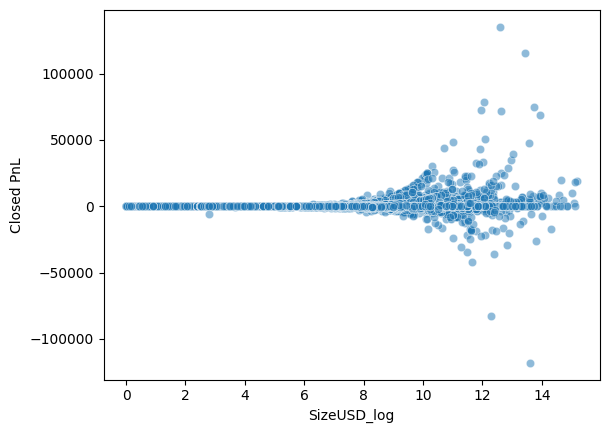

In [88]:
merged_df['SizeUSD_log'] = np.log1p(merged_df['Size USD'])
sns.scatterplot(x='SizeUSD_log', y='Closed PnL', data=merged_df, alpha=0.5)
plt.show()
plt.savefig(os.path.join(output_dir, "PnL_vs_Size_USD"), dpi=300, bbox_inches='tight')
plt.close()

#**PnL**

In [89]:
merged_df.groupby('classification')['Closed PnL'].mean()

,Closed PnL
classification,
Extreme Fear,34.537862
Extreme Greed,67.892861
Fear,54.290400
Greed,42.743559
Neutral,34.307718


/tmp/ipython-input-193837934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


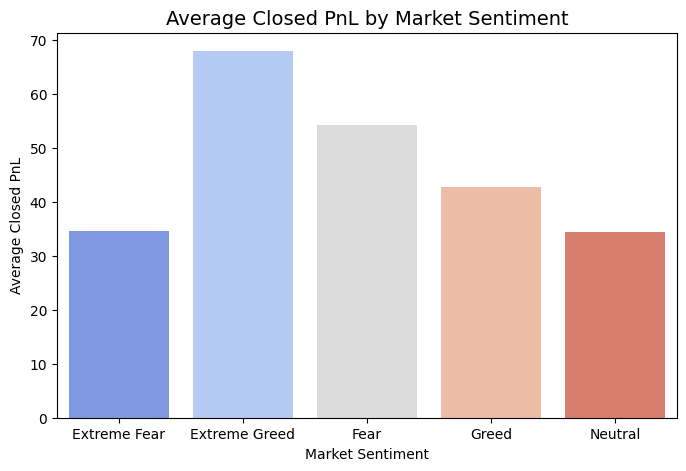

In [90]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='classification',
    y='Closed PnL',
    data=merged_df.groupby('classification')['Closed PnL'].mean().reset_index(),
    palette='coolwarm'
)
plt.title('Average Closed PnL by Market Sentiment', fontsize=14)
plt.ylabel('Average Closed PnL')
plt.xlabel('Market Sentiment')
plt.show()
plt.savefig(os.path.join(output_dir, "Sentiment_vs_Avg_PnL"), dpi=300, bbox_inches='tight')
plt.close()

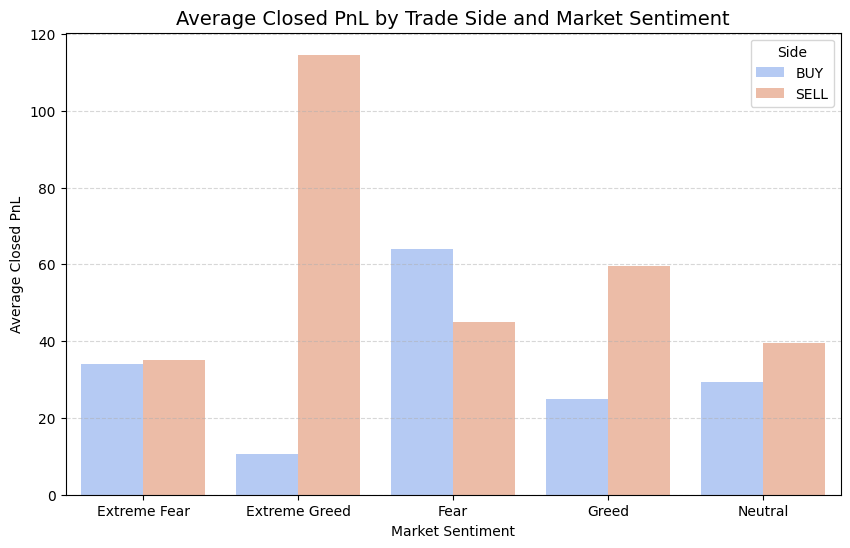

In [91]:
pnl_by_side = merged_df.groupby(['classification', 'Side'])['Closed PnL'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(
    x='classification',
    y='Closed PnL',
    hue='Side',            # separates Buy and Sell
    data=pnl_by_side,
    palette='coolwarm'
)
plt.title('Average Closed PnL by Trade Side and Market Sentiment', fontsize=14)
plt.xlabel('Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
plt.savefig(os.path.join(output_dir, "Sentiment_PnL_Side"), dpi=300, bbox_inches='tight')
plt.close()

Adding the merged df for further processing

In [92]:
import pickle

agg_merged_df.to_pickle(os.path.join(root_dir, "agg_merged_df.pkl"))
agg_merged_df.to_csv(os.path.join(root_dir, "agg_merged_df.csv"))

merged_df.to_pickle(os.path.join(root_dir, "merged_df.pkl"))
merged_df.to_csv(os.path.join(root_dir, "merged_df.csv"))
